# **Smartphone Image with Dirty Lenses (SIDL) Dataset: NAFNet Online Demo**


---



# **✅ Please make sure you’ve enabled GPU in Colab before running the setup.**
---







이미지 사이즈에 따른 GPU메모리? 100퍼 안쓰면 code optimization이 안된거임.

## **Mount Google Drive & Git clone [NAFNet](https://github.com/megvii-research/NAFNet) repo**

<strong><font color="#d9534f">***Note:***</font></strong> *: If you are not a first-time user, running (a) will overwrite the existing repository.*

(a) Run the following code on your first attempt:

In [4]:
# Run the following code on your first attempt:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Colab Notebooks/2025_ML/20233011_김연서
!git clone https://github.com/megvii-research/NAFNet
%cd NAFNet

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/2025_ML/20233011_김연서
Cloning into 'NAFNet'...
remote: Enumerating objects: 521, done.
remote: Counting objects: 100% (225/225), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 521 (delta 180), reused 142 (delta 142), pack-reused 296 (from 1)
Receiving objects: 100% (521/521), 16.19 MiB | 12.54 MiB/s, done.
Resolving deltas: 100% (277/277), done.
/content/drive/MyDrive/Colab Notebooks/2025_ML/20233011_김연서/NAFNet


(b) From the next time, run this code only:

In [ ]:
# From the next time, run this code only:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Colab Notebooks/2025_ML/20233011_김연서/NAFNet

Mounted at /content/drive
/content/drive/MyDrive/NAFNet


## **Set up the enviroment**

In [5]:
!pip install -r requirements.txt
!pip install --upgrade --no-cache-dir gdown
!pip install calflops
!python3 setup.py develop --no_cuda_ext

/usr/local/lib/python3.11/dist-packages/setuptools/__init__.py:94: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated.
!!

        ********************************************************************************
        Requirements should be satisfied by a PEP 517 installer.
        If you are using pip, you can try `pip install --use-pep517`.
        ********************************************************************************

!!
  dist.fetch_build_eggs(dist.setup_requires)
running develop
/usr/local/lib/python3.11/dist-packages/setuptools/command/develop.py:41: EasyInstallDeprecationWarning: easy_install command is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` and ``easy_install``.
        Instead, use pypa/build, pypa/installer or other
        standards-based tools.

        See https://github.com/pypa/setuptools/issues/917 for details.
        *****

# **Getting Started with the SIDL Dataset on Google Drive**

## Adding Google Drive Shortcuts to My Drive

**Please add the following Google Drive folders as shortcuts in your “My Drive”:**

1. **Train**  
   https://drive.google.com/drive/folders/1B7cRduVyGyicrDwX25i1TeaBQhzGvpF0?usp=sharing  
2. **Validation**  
   https://drive.google.com/drive/folders/1XdvZI5vrc6rluIVYUzTXRuzZV1m6unfM?usp=sharing  
3. **Test**  
   https://drive.google.com/drive/folders/18CWJ5EIn1FP9Ayap5MEdmHEdQvaU7xT9?usp=sharing  

**How to add each folder as a shortcut:**
- Open the link above in your browser.  
- Click the “Add shortcut to Drive” icon.  
- Choose **My Drive** as the location and confirm.

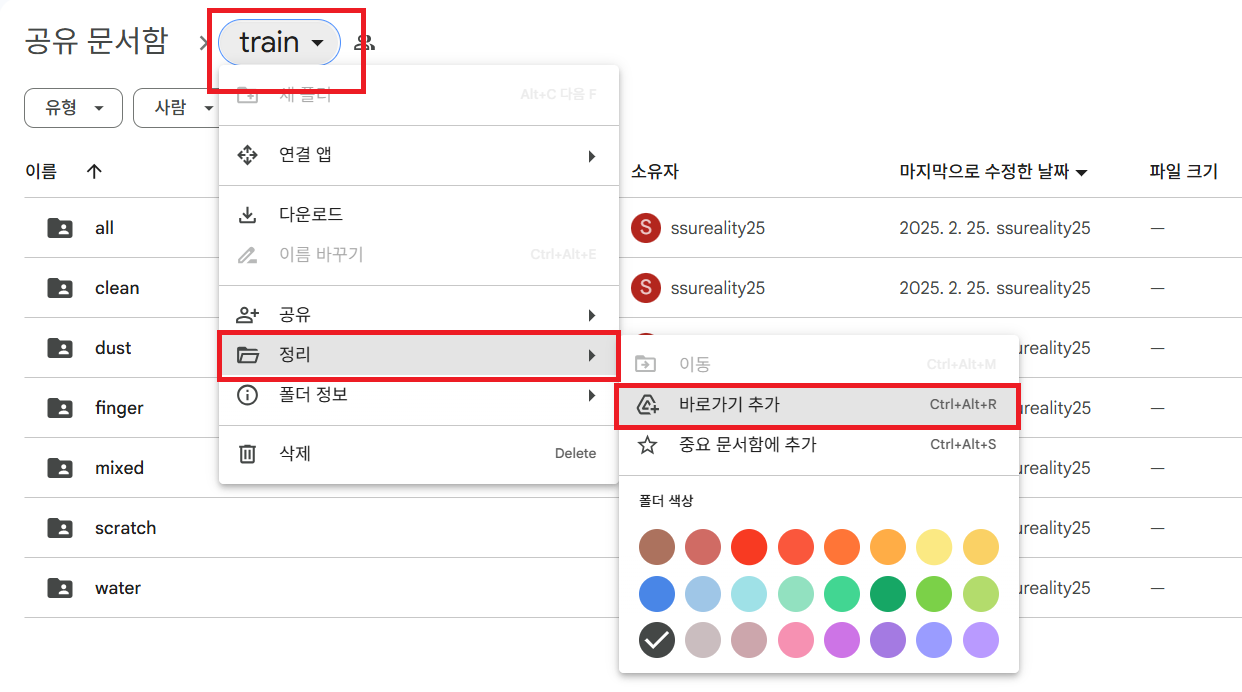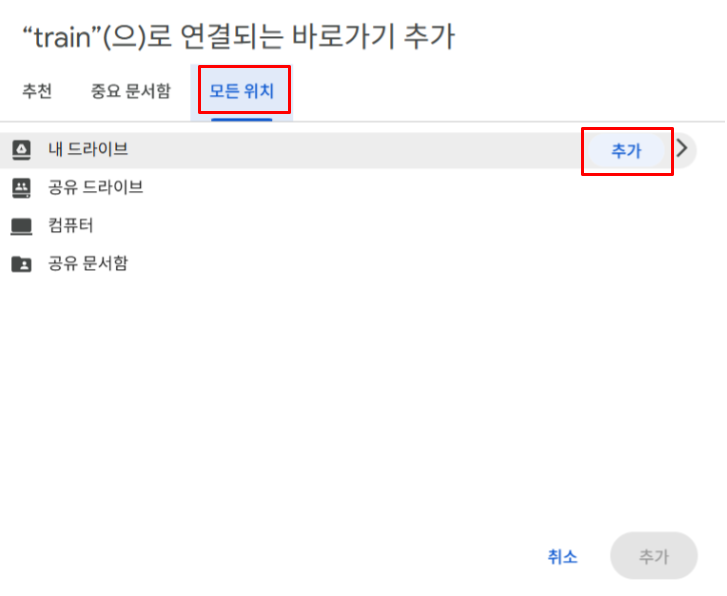

# **Make custom yml file for training**

In [6]:
import os

# 0) Define and create the experiment root directory
experiment_root = '/content/drive/MyDrive/Colab Notebooks/2025_ML/20233011_김연서/NAFNet_experiments/SIDL_water'
os.makedirs(experiment_root, exist_ok=True)

# 1) Output directory: ensure it exists
out_dir = '/content/drive/MyDrive/Colab Notebooks/2025_ML/20233011_김연서/sidl_options/train'
os.makedirs(out_dir, exist_ok=True)

# 2) Specify the single task for which to generate the config
task = 'water' # ['clean', 'water', 'finger', 'dust', 'mixed', 'scratch']

# 3) Define validation difficulty levels: choose from 'easy', 'medium', 'hard'
# Select one difficulty for the current configuration

difficulty = 'hard'

In [7]:
# 4) YAML template with a placeholder for {task}
template = f"""\
# ------------------------------------------------------------------------
# Configuration for NAFNet on SIDL-{task} (validation difficulty: {difficulty})
# ------------------------------------------------------------------------

# Paths for pretrained weights and resume checkpoints
path:
  root: /content/drive/MyDrive/Colab Notebooks/2025_ML/20233011_김연서/NAFNet_experiments
  pretrain_network_g: ~
  strict_load_g: true
  resume_state: ~


name: NAFNet-SIDL-{task}-width32
model_type: ImageRestorationModel
scale: 1
num_gpu: 1           # Use a single GPU (typical in Colab)
manual_seed: 42

datasets:
  # ----------------------------------------------------------------------
  #                          TRAINING DATASET
  # ----------------------------------------------------------------------
  train:
    name: sidl-{task}-train
    type: PairedImageDataset
    dataroot_gt: /content/drive/MyDrive/Colab Notebooks/2025_ML/20233011_김연서/train/{task}/target
    dataroot_lq: /content/drive/MyDrive/Colab Notebooks/2025_ML/20233011_김연서/train/{task}/input
    io_backend:
      type: disk
    gt_size: 64
    use_flip: true
    use_rot: true
    use_shuffle: true
    num_worker_per_gpu: 2
    batch_size_per_gpu: 8

  # ----------------------------------------------------------------------
  #                          VALIDATION DATASET
  # ----------------------------------------------------------------------
  val:
    name: sidl-{task}-{difficulty}-val
    type: PairedImageDataset
    dataroot_gt: /content/drive/MyDrive/Colab Notebooks/2025_ML/20233011_김연서/val/{task}/{difficulty}/target
    dataroot_lq: /content/drive/MyDrive/Colab Notebooks/2025_ML/20233011_김연서/val/{task}/{difficulty}/input
    io_backend:
      type: disk



# ----------------------------------------------------------------------
#                    NETWORK & TRAINING SETTINGS
# ----------------------------------------------------------------------


# Network architecture settings
network_g:
  type: NAFNetLocal
  width: 16                    # 8 , 32
  enc_blk_nums: [1, 1, 1, 8]  # [1, 1, 1, 1] , [2, 2, 4, 8], [1,1,1,28]
  middle_blk_num: 1           # 2 , 12 ,1
  dec_blk_nums: [1, 1, 1, 1]  # [1, 1, 1, 1] , [2, 2, 2, 2], [1,1,1,1]



# Training hyperparameters
train:
  optim_g:
    type: AdamW
    lr: !!float 1e-3
    weight_decay: !!float 1e-3
    betas: [0.9, 0.9]
  scheduler:
    type: TrueCosineAnnealingLR
    T_max: 200000
    eta_min: !!float 1e-7
  total_iter: 200000
  warmup_iter: -1      # No warm-up
  pixel_opt:
    type: PSNRLoss
    loss_weight: 1
    reduction: mean

# Validation settings
val:
  val_freq: !!float 2000
  save_img: True
  metrics:
    psnr:
      type: calculate_psnr
      crop_border: 0
      test_y_channel: false
    ssim:
      type: calculate_ssim
      crop_border: 0
      test_y_channel: false

# Logging configuration (TensorBoard, WandB)
logger:
  print_freq: !!float 10
  save_checkpoint_freq: !!float 2000
  use_tb_logger: true
  wandb:
    project: ~
    resume_id: ~

# Distributed training parameters (not used in single-GPU mode)
dist_params:
  backend: nccl
  port: 29500
"""

# 4) Fill in the task placeholder and write the YAML to a file
out_path = os.path.join(out_dir, f'SIDL_{task}.yml')
with open(out_path, 'w') as f:
    f.write(template)

print(f'✅ Generated config with experiment_root: {out_path}')


✅ Generated config with experiment_root: /content/drive/MyDrive/Colab Notebooks/2025_ML/20233011_김연서/sidl_options/train/SIDL_water.yml


# **Training NAFNet for a Specific Task**

---



In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/2025_ML/20233011_김연서/NAFNet

!torchrun \
  --standalone \
  --nnodes=1 \
  --nproc_per_node=1 \
  --master_port=4311 \
  basicsr/train.py \
    -opt /content/drive/MyDrive/Colab\ Notebooks/2025_ML/20233011_김연서/sidl_options/train/SIDL_water.yml \
    --launcher pytorch

/content/drive/MyDrive/Colab Notebooks/2025_ML/20233011_김연서/NAFNet
init dist ..  pytorch
2025-05-09 05:27:26,958 INFO: 
                ____                _       _____  ____
               / __ ) ____ _ _____ (_)_____/ ___/ / __ \
              / __  |/ __ `// ___// // ___/\__ \ / /_/ /
             / /_/ // /_/ /(__  )/ // /__ ___/ // _, _/
            /_____/ \__,_//____//_/ \___//____//_/ |_|
     ______                   __   __                 __      __
    / ____/____   ____   ____/ /  / /   __  __ _____ / /__   / /
   / / __ / __ \ / __ \ / __  /  / /   / / / // ___// //_/  / /
  / /_/ // /_/ // /_/ // /_/ /  / /___/ /_/ // /__ / /<    /_/
  \____/ \____/ \____/ \____/  /_____/\____/ \___//_/|_|  (_)
    
Version Information: 
	BasicSR: 1.2.0+2b4af71
	PyTorch: 2.6.0+cu124
	TorchVision: 0.21.0+cu124
2025-05-09 05:27:26,959 INFO: 
  path:[
    root: /content/drive/MyDrive/Colab Notebooks/2025_ML/20233011_김연서/NAFNet
    pretrain_network_g: None
    strict_load_g: True
    r

# **Inference**

---


# **Make custom yml file for inference**

In [ ]:
import os


# 0) Define and create the experiment root directory
experiment_root = '/content/drive/MyDrive/Colab Notebooks/2025_ML/20233011_김연서/NAFNet_results'
os.makedirs(experiment_root, exist_ok=True)

# 1) Output directory: ensure it exists
out_dir = '/content/drive/MyDrive/Colab Notebooks/2025_ML/20233011_김연서/sidl_options/test'
os.makedirs(out_dir, exist_ok=True)

# 2) Specify the single task for which to generate the config
task = 'water' # ['clean', 'water', 'finger', 'dust', 'mixed', 'scratch']

# 3) Define validation difficulty levels: choose from 'easy', 'medium', 'hard'
# Select one difficulty for the current configuration

difficulty_levels = ['easy', 'medium', 'hard']


ckpt_path = '/content/drive/MyDrive/Colab Notebooks/2025_ML/20233011_김연서/NAFNet/experiments/NAFNet-SIDL-water-width32/models/net_g_1.pth'

In [ ]:
# 4) YAML template with a placeholder for {task} all levels.


for difficulty in difficulty_levels:

  template = f"""\
# ------------------------------------------------------------------------
# Configuration for NAFNet on SIDL-{task} (validation difficulty: {difficulty})
# ------------------------------------------------------------------------

# Paths for pretrained weights and resume checkpoints
path:
  root: /content/drive/MyDrive/Colab Notebooks/2025_ML/20233011_김연서/NAFNet_experiments
  pretrain_network_g: {ckpt_path}
  strict_load_g: true
  resume_state: ~


name: NAFNet-SIDL-{task}-{difficulty}-width32-test
model_type: ImageRestorationModel
scale: 1
num_gpu: 1           # Use a single GPU (typical in Colab)
manual_seed: 42

datasets:
  # ----------------------------------------------------------------------
  #                          TEST DATASET
  # ----------------------------------------------------------------------
  test:
    name: sidl-{task}-{difficulty}-test
    type: PairedImageDataset
    dataroot_gt: /content/drive/MyDrive/Colab Notebooks/2025_ML/20233011_김연서/test/{task}/{difficulty}/input
    dataroot_lq: /content/drive/MyDrive/Colab Notebooks/2025_ML/20233011_김연서/test/{task}/{difficulty}/input
    io_backend:
      type: disk



# ----------------------------------------------------------------------
#                           NETWORK SETTINGS
# ----------------------------------------------------------------------


# Network architecture settings
network_g:
  type: NAFNetLocal
  width: 16                    # 8 , 32
  enc_blk_nums: [1, 1, 1, 1]  # [1, 1, 1, 1] , [2, 2, 4, 8]
  middle_blk_num: 4           # 2 , 12
  dec_blk_nums: [1, 1, 1, 1]  # [1, 1, 1, 1] , [2, 2, 2, 2]



# Validation settings
val:
  save_img: True
  metrics:
    psnr:
      type: calculate_psnr
      crop_border: 0
      test_y_channel: false
    ssim:
      type: calculate_ssim
      crop_border: 0
      test_y_channel: false

# Distributed training parameters (not used in single-GPU mode)
dist_params:
  backend: nccl
  port: 29500
"""

  # 4) Fill in the task placeholder and write the YAML to a file
  out_path = os.path.join(out_dir, f'SIDL_{task}_{difficulty}.yml')
  with open(out_path, 'w') as f:
      f.write(template)

  print(f'✅ Generated config with experiment_root: {out_path}')


✅ Generated config with experiment_root: /content/drive/MyDrive/sidl_options/test/SIDL_water_easy.yml
✅ Generated config with experiment_root: /content/drive/MyDrive/sidl_options/test/SIDL_water_medium.yml
✅ Generated config with experiment_root: /content/drive/MyDrive/sidl_options/test/SIDL_water_hard.yml


# **Run Inference (Easy • Medium • Hard)**


---


<strong><font color="#d9534f">***Note:***</font></strong> *PSNR and SSIM metrics are not computed against ground truth in this notebook; please use the Online evaluation to view these results.*


In [ ]:
# 1) Change into the NAFNet repository directory
%cd /content/drive/MyDrive/Colab Notebooks/2025_ML/20233011_김연서/NAFNet

# 2) Loop over each difficulty level and run inference
for diff in ['easy', 'medium', 'hard']:
    print(f"========== Testing difficulty: {diff} ==========")
    !torchrun --standalone \
      --nnodes=1 \
      --nproc_per_node=1 \
      --master_port=4311 \
      basicsr/test.py \
      -opt /content/drive/MyDrive/Colab Notebooks/2025_ML/20233011_김연서/sidl_options/test/SIDL_water_{diff}.yml \
      --launcher pytorch


# 3) Note that PSNR and SSIM metrics are not computed against ground truth in this notebook; please use the Online evaluation to view these results.

/content/NAFNet
init dist ..  pytorch
Path already exists. Rename it to /content/NAFNet/results/NAFNet-SIDL-water-hard-width32-test_archived_20250423_084608
2025-04-23 08:46:08,027 INFO: 
                ____                _       _____  ____
               / __ ) ____ _ _____ (_)_____/ ___/ / __ \
              / __  |/ __ `// ___// // ___/\__ \ / /_/ /
             / /_/ // /_/ /(__  )/ // /__ ___/ // _, _/
            /_____/ \__,_//____//_/ \___//____//_/ |_|
     ______                   __   __                 __      __
    / ____/____   ____   ____/ /  / /   __  __ _____ / /__   / /
   / / __ / __ \ / __ \ / __  /  / /   / / / // ___// //_/  / /
  / /_/ // /_/ // /_/ // /_/ /  / /___/ /_/ // /__ / /<    /_/
  \____/ \____/ \____/ \____/  /_____/\____/ \___//_/|_|  (_)
    
Version Information: 
	BasicSR: 1.2.0+2b4af71
	PyTorch: 2.6.0+cu124
	TorchVision: 0.21.0+cu124
2025-04-23 08:46:08,028 INFO: 
  path:[
    root: /content/NAFNet
    pretrain_network_g: /content/drive/MyDrive

# **Efficiency Check**

In [ ]:
import os
import sys
import time
import torch
import yaml
from calflops import calculate_flops

# 1) Make sure the NAFNet repo is on your PYTHONPATH
sys.path.append('/content/drive/MyDrive/Colab Notebooks/2025_ML/20233011_김연서/NAFNet/')
from basicsr.models import create_model

def main():
    # ——— 1) Load YAML configuration ———
    yaml_path = "/content/drive/MyDrive/Colab Notebooks/2025_ML/20233011_김연서/sidl_options/test/SIDL_water_easy.yml"
    if not os.path.isfile(yaml_path):
        raise FileNotFoundError(f"Config file not found:\n  {yaml_path}")
    with open(yaml_path, 'r') as f:
        opt = yaml.safe_load(f)

    # Disable training and distributed flags
    opt['is_train'] = False
    opt['dist']     = False

    # ——— 2) Build the model ———
    model_wrapper = create_model(opt)
    net_g = model_wrapper.net_g.eval().cuda()

    # ——— 3) Define dummy input shape (batch_size, channels, height, width) ———
    input_shape = (1, 3, 512, 512)
    dummy_input = torch.randn(input_shape, device='cuda')

    # ——— 4) Compute FLOPs & parameter count ———
    with torch.no_grad():
        flops, gmacs, params = calculate_flops(
            model=net_g,
            input_shape=input_shape,
            output_as_string=True,
            output_precision=4
        )

    # ——— 5) Measure average inference time ———
    # Warm up GPU caches and kernels
    for _ in range(10):
        _ = net_g(dummy_input)
    # Synchronize before timing
    torch.cuda.synchronize()
    n_runs = 100
    start = time.perf_counter()
    for _ in range(n_runs):
        _ = net_g(dummy_input)
    torch.cuda.synchronize()
    end = time.perf_counter()

    avg_time_ms = (end - start) / n_runs * 1000

    # ——— 6) Print all results ———
    print(f"Configuration name: {opt.get('name', 'NAFNet_SIDL')}")
    print(f"FLOPs:               {flops}")
    print(f"GMACs:               {gmacs}")
    print(f"# Params:            {params}")
    print(f"Avg inference time:  {avg_time_ms:.2f} ms per 512×512 image")

if __name__ == "__main__":
    main()


 load net keys <built-in method keys of collections.OrderedDict object at 0x7e2a6de720c0>

------------------------------------- Calculate Flops Results -------------------------------------
Notations:
number of parameters (Params), number of multiply-accumulate operations(MACs),
number of floating-point operations (FLOPs), floating-point operations per second (FLOPS),
fwd FLOPs (model forward propagation FLOPs), bwd FLOPs (model backward propagation FLOPs),
default model backpropagation takes 2.00 times as much computation as forward propagation.

Total Training Params:                                                  17.11 M 
fwd MACs:                                                               73.479 GMACs
fwd FLOPs:                                                              147.518 GFLOPS
fwd+bwd MACs:                                                           220.437 GMACs
fwd+bwd FLOPs:                                                          442.553 GFLOPS

------------------

# **Online Evaluation**

---


# **[SIDL Online Evaluation](http://203.253.25.170:8080/)**
Ready your submission .tar archive here for evaluation.

---


Single-Task Submission Script


---

In [ ]:
import os
import shutil
import glob
import tarfile

# 1) Define the task and difficulty levels for the submission
#    Logical task name:
task = 'water'  # Choose from: ['clean', 'water', 'finger', 'dust', 'mixed', 'scratch']
#    On-disk folder name (map 'finger' → 'fingerprint')
display_task = 'fingerprint' if task == 'finger' else task

difficulty_levels = ['easy', 'medium', 'hard']

# 2) Set up source directories for each difficulty level in Google Drive
base_path = "/content/drive/MyDrive/Colab Notebooks/2025_ML/20233011_김연서/NAFNet_results"
source_dirs = {
    diff: os.path.join(base_path, f"NAFNet-SIDL-{task}-{diff}-width32-test/visualization/sidl-{task}-{diff}-test")
    for diff in difficulty_levels
}

# 3) Create a temporary directory to organize the submission structure
temp_dir = "/content/drive/MyDrive/Colab Notebooks/2025_ML/20233011_김연서/temp_submission"
os.makedirs(temp_dir, exist_ok=True)

# 4) Create the task directory (e.g., 'fingerprint') for the submission
task_dir = os.path.join(temp_dir, display_task)
os.makedirs(task_dir, exist_ok=True)

# 5) Organize files by difficulty level, copying only non-_gt PNGs into the submission structure
for diff in difficulty_levels:
    input_dir = os.path.join(task_dir, diff, "input")
    os.makedirs(input_dir, exist_ok=True)
    source_dir = source_dirs[diff]
    png_files = glob.glob(os.path.join(source_dir, "*.png"))
    non_gt_files = [f for f in png_files if not f.endswith("_gt.png")]
    for file in non_gt_files:
        shutil.copy(file, input_dir)

# 6) Create a tar file with the organized structure and save it to Google Drive
tar_path = f"/content/drive/MyDrive/Colab Notebooks/2025_ML/20233011_김연서/NAFNet_results/submission_{display_task}.tar"
with tarfile.open(tar_path, "w") as tar:
    tar.add(task_dir, arcname=display_task)

# 7) Confirm the location of the created tar file
print(f"Tar file created at: {tar_path}")

# 8) Display the expected structure inside the tar file for reference
print("\nInternal structure of the tar file:")
print(f"{display_task}/")
for diff in difficulty_levels:
    print(f"  ├── {diff}/")
    print(f"  │   └── input/")
    input_dir = os.path.join(task_dir, diff, "input")
    files = os.listdir(input_dir)
    if files:
        for i, file in enumerate(files[:5]):
            more = "" if i == min(4, len(files)-1) else " (and more...)"
            print(f"  │       ├── {file}{more}")
    else:
        print("  │       └── (no files)")

# 9) Clean up the temporary directory after creating the tar file
shutil.rmtree(temp_dir)


---


Multi-Task Submission Script


---

In [ ]:
import os
import shutil
import glob
import tarfile

# 1) List of damage types to include in the submission
tasks_to_submit = ['dust', 'scratch']  # e.g., ['clean', 'dust', 'scratch', 'mixed', 'water']

#    Map 'finger' to 'fingerprint' for folder naming
def display_name(task):
    return 'fingerprint' if task == 'finger' else task

# 2) Difficulty levels
difficulty_levels = ['easy', 'medium', 'hard']

# 3) Base directory on Google Drive containing the results
base_path = "/content/drive/MyDrive/Colab Notebooks/2025_ML/20233011_김연서/NAFNet_results"

# 4) Create a temporary working directory
temp_dir = "/content/drive/MyDrive/Colab Notebooks/2025_ML/20233011_김연서/temp_multi_submission"
if os.path.exists(temp_dir):
    shutil.rmtree(temp_dir)
os.makedirs(temp_dir, exist_ok=True)

# 5) Build folder structure and copy files for each damage type
for task in tasks_to_submit:
    disp = display_name(task)
    task_dir = os.path.join(temp_dir, disp)
    os.makedirs(task_dir, exist_ok=True)

    for diff in difficulty_levels:
        input_dir = os.path.join(task_dir, diff, "input")
        os.makedirs(input_dir, exist_ok=True)

        src_dir = os.path.join(
            base_path,
            f"NAFNet-SIDL-{task}-{diff}-width32-test",
            "visualization",
            f"sidl-{task}-{diff}-test"
        )
        # Copy all PNG files except those ending with '_gt.png'
        for p in glob.glob(os.path.join(src_dir, "*.png")):
            if not p.endswith("_gt.png"):
                shutil.copy(p, input_dir)

# 6) Define the final archive path and create the tar
archive_name = "submission_" + "_".join(tasks_to_submit) + ".tar"
archive_path = os.path.join(base_path, archive_name)
with tarfile.open(archive_path, "w") as tar:
    for disp in map(display_name, tasks_to_submit):
        tar.add(os.path.join(temp_dir, disp), arcname=disp)

# Print the location of the created archive
print(f"Tar file created at: {archive_path}\n")

# 7) Print internal structure of the tar file with up to 5 entries per directory
print("Internal structure of the tar file:")

def print_limited_tree(root, prefix=""):
    items = sorted(os.listdir(root))
    # Limit to 5 items
    shown = items[:5]
    more_flag = len(items) > 5
    for i, name in enumerate(shown):
        path = os.path.join(root, name)
        is_last = (i == len(shown) - 1 and not more_flag)
        connector = "└── " if is_last else "├── "
        suffix = " (and more...)" if more_flag else ""
        print(prefix + connector + name + suffix)
        if os.path.isdir(path):
            extension = "    " if is_last else "│   "
            print_limited_tree(path, prefix + extension)

# Walk top-level task dirs
for task in tasks_to_submit:
    disp = display_name(task)
    print(f"{disp}/")
    task_dir = os.path.join(temp_dir, disp)
    # Print substructure under each
    sub_prefix = "  "
    print_limited_tree(task_dir, sub_prefix)



# Clean up the temporary directory
shutil.rmtree(temp_dir)
